In [1]:
# Standard library imports
import matplotlib.pyplot as plt
from pathlib import Path

# Third-party imports
import nibabel as nib

# MONAI imports
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityRanged,
    CropForegroundd,
    Spacingd,
    Orientationd,
    Resized,
    Invertd,
    ToTensord,
    LabelToContourd,
    LabelFilterd,
    allow_missing_keys_mode
)
from monai.transforms.compose import Compose
from monai.utils import first, set_determinism
from monai.visualize.utils import blend_images, matshow3d
from monai.utils.enums import CommonKeys

In [2]:
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.7.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/medenv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.22.0+cu126
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.22.0
pynrrd version: 1.1.3
clearml version: 2.0.0rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# Data setup
covid_root_dir = Path("data/")
assert covid_root_dir.exists(), f"Please download the dataset from {covid_root_dir} and unzip it."

# Define paths
raw_images_path = covid_root_dir / "COVID-19-CT-Seg_20cases"
masks_path = covid_root_dir / "Infection_Mask"

# Get file lists
raw_images = sorted(raw_images_path.glob("*.nii.gz"))
masks = sorted(masks_path.glob("*.nii.gz"))
assert len(raw_images) == len(masks), "Number of images and masks do not match."

In [4]:
data = {}
for i, (img, seg) in enumerate(zip(raw_images, masks)):
    data[i] = {
        CommonKeys.IMAGE: str(img),
        CommonKeys.LABEL: str(seg),
    }
print(f"Number of images: {len(data)}")
# Print the first image and mask paths
print(f"First image path: {data[0][CommonKeys.IMAGE]}")
print(f"First mask path: {data[0][CommonKeys.LABEL]}")

Number of images: 20
First image path: data/COVID-19-CT-Seg_20cases/coronacases_001.nii.gz
First mask path: data/Infection_Mask/coronacases_001.nii.gz


In [5]:

set_determinism(seed=121567888)

# Define common keys to avoid repetition
img_key = CommonKeys.IMAGE
label_key = CommonKeys.LABEL
both_keys = [img_key, label_key]

transform = Compose([
    LoadImaged(keys=both_keys, reader="NibabelReader"),
    EnsureChannelFirstd(keys=both_keys),
    ScaleIntensityRanged(
        keys=[img_key],
        a_min=-1000,
        a_max=400,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    Spacingd(
        keys=both_keys,
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    Orientationd(
         keys=both_keys,
         axcodes=("RAS"), # Axis 0 -> R, Axis 1 -> A, Axis 2 -> S, so 0 are thre rows (Y), 1 are the columns (X), and 2 are the slices (Z)
    ),
    CropForegroundd(
        keys=both_keys,
        source_key=img_key,
        margin=10,
    ),
    LabelFilterd(
        keys=[label_key],
        applied_labels=[0,1,]
    ),
    # LabelToContourd(
    #     keys=["seg"],
    # ),
])

# Create a PersistentDataset
train_ds = CacheDataset(
    data=data,
    transform=transform,
    cache_rate=0.05,
)
# Create a DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

from monai.utils import first

# Get a batch of data
batch_data = first(train_loader)
# Print the shape of the image and mask tensors
print(f"Image shape: {batch_data[img_key].shape}")
print(f"Mask shape: {batch_data[label_key].shape}")


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
Loading dataset: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Image shape: torch.Size([1, 1, 431, 431, 265])
Mask shape: torch.Size([1, 1, 431, 431, 265])


In [6]:
blended_imgs = blend_images(
    batch_data[img_key][0],
    batch_data[label_key][0],
    alpha=0.3,
)

## Vistas axiales, coronales y sagitales

En imagenología médica, existen tres planos principales para visualizar estructuras anatómicas:

- **Vista axial (transversal):** Es un corte horizontal que divide el cuerpo en partes superior e inferior. Se observa como si se mirara el cuerpo desde los pies hacia la cabeza.
- **Vista coronal (frontal):** Es un corte vertical que divide el cuerpo en partes anterior (frontal) y posterior (trasera). Se observa como si se mirara el cuerpo de frente.
- **Vista sagital:** Es un corte vertical que divide el cuerpo en partes izquierda y derecha. Si el corte es exactamente en la línea media, se denomina sagital media; si es paralelo a esta, se llama parasagital.

Estas vistas permiten analizar la anatomía y las patologías desde diferentes perspectivas, facilitando el diagnóstico y la planificación de tratamientos.

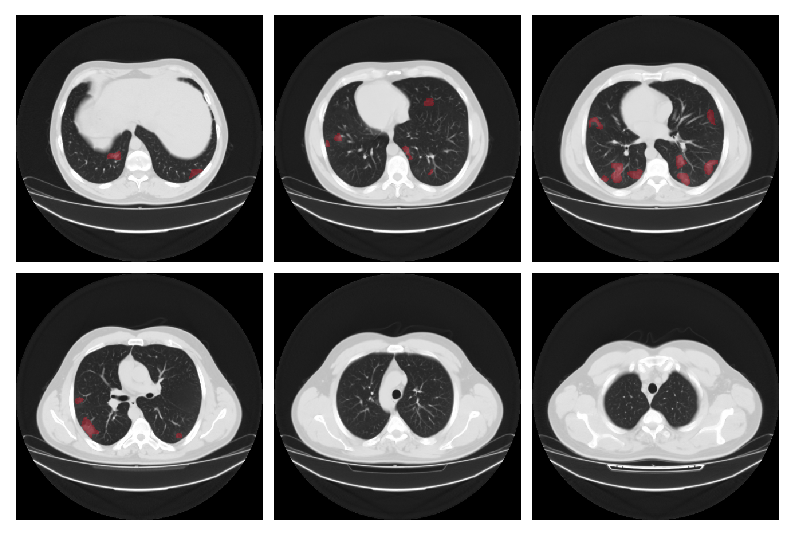

In [7]:
matshow3d(
    blended_imgs.transpose(1,2), # Transpose to match matplotlib's expected input
    channel_dim=0,
    frame_dim=-1,
    fig=plt.figure(figsize=(100, 100)),
    margin=10,
    every_n=50,
)
plt.savefig("blended_imgs.png", dpi=500)

### Cortes coronales

Intercambiando los ejes 2 y 3 (`transpose(2,3)`) se obtienen los cortes coronales, que muestran el cuerpo de frente a atrás.

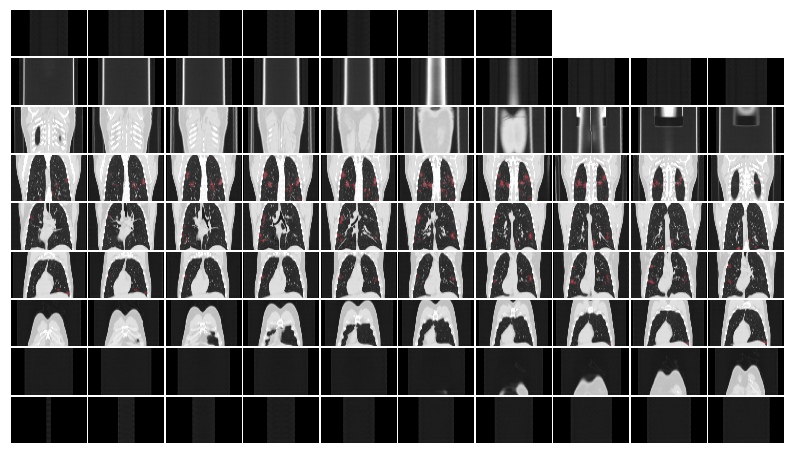

In [16]:
matshow3d(
    blended_imgs.permute(0,3,1,2),  # Intercambia los ejes 2 y 3 para cortes coronales
    channel_dim=0,
    frame_dim=-1,
    fig=plt.figure(figsize=(100, 100)),
    margin=5,
    every_n=5,  # Cambia el origen a "lower" para que la imagen se vea correctamente
    origin="lower",
)
plt.savefig("blended_imgs_coronal.png", dpi=500)

### Cortes sagitales

Intercambiando los ejes 1 y 3 (`transpose(1,3)`) se obtienen los cortes sagitales, que muestran el cuerpo de lado a lado.

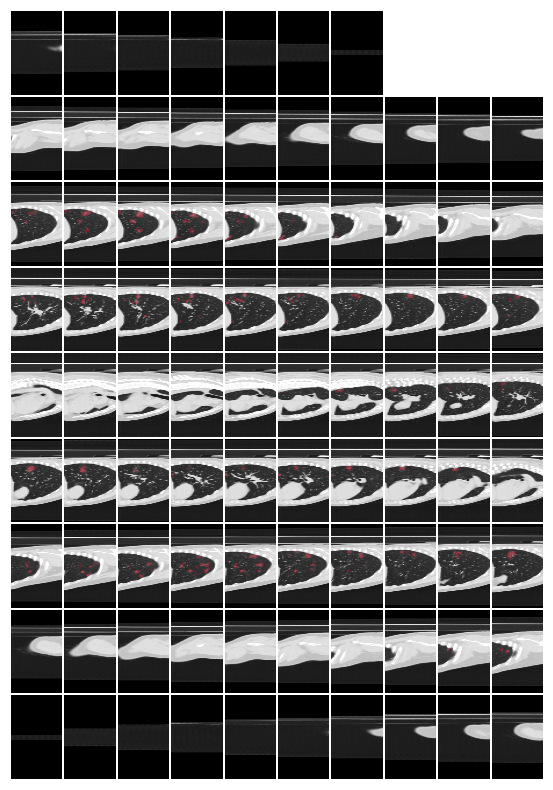

In [20]:
matshow3d(
    blended_imgs.permute(0,2,3,1),  # Intercambia los ejes 1 y 3 para cortes sagitales
    channel_dim=0,
    frame_dim=-1,
    fig=plt.figure(figsize=(100, 100)),
    margin=5,
    every_n=5,
    origin="lower"
)
plt.savefig("blended_imgs_sagittal.png", dpi=500)

In [ ]:
with allow_missing_keys_mode(transform):
    # Invert the transform including both image and segmentation
    data_to_invert = {
        img_key: batch_data[img_key][0],
        label_key: batch_data[label_key][0],
    }
    inverted_data = transform.inverse(data_to_invert)
    # Print the shape of the inverted image and mask tensors
    print(f"Inverted image shape: {inverted_data[img_key].shape}")
    print(f"Inverted mask shape: {inverted_data[label_key].shape}")

Inverted image shape: torch.Size([1, 630, 630, 45])
Inverted mask shape: torch.Size([1, 630, 630, 45])


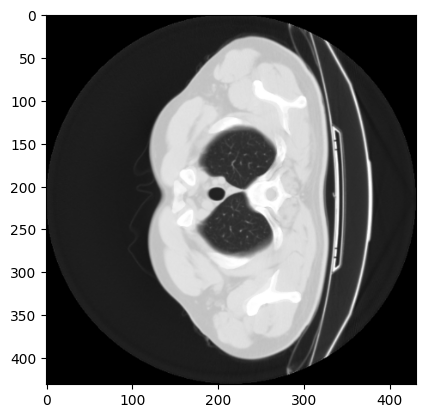

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch_data[img_key][0, 0, :, :, 260].cpu(), cmap="gray")
plt.show()

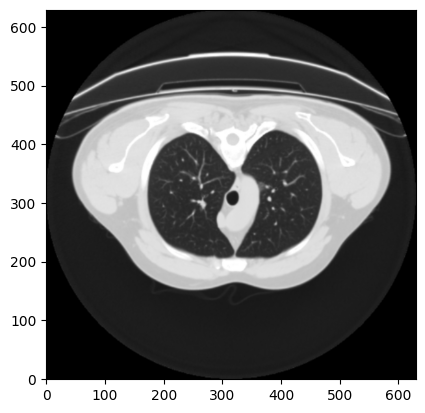

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(inverted_data[img_key][0, :, :, 34].transpose(0,1).cpu(), cmap="gray", origin="lower")
plt.show()

In [ ]:
# Nibabel loading
vol = nib.load(data[0][img_key])
print(f"Image shape: {vol.shape}")
print(f"Image affine: {vol.affine}")
print(nib.aff2axcodes(vol.affine))
matrix = vol.get_fdata()

Image shape: (512, 512, 301)
Image affine: [[  -0.81054699    0.            0.          213.10714722]
 [  -0.            0.81054699    0.         -206.89215088]
 [   0.           -0.            1.         -220.05334473]
 [   0.            0.            0.            1.        ]]
('L', 'A', 'S')


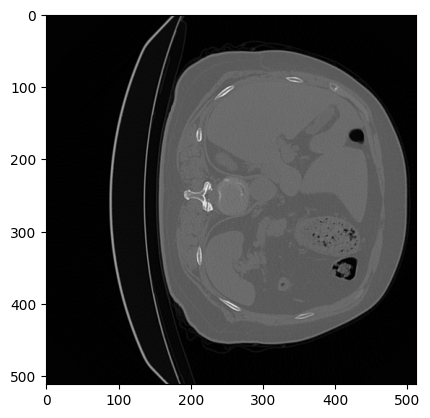

In [ ]:
plt.imshow(matrix[:, :, 34], cmap="gray")
plt.show()

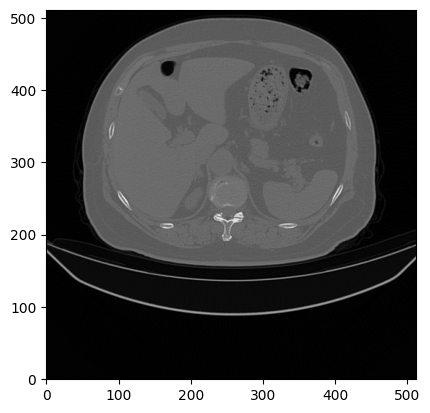

In [ ]:
plt.imshow(matrix[:, :, 34].T, cmap="gray", origin="lower")
plt.show()

## Errores en los metadatos



In [ ]:
result = transform(data[0])

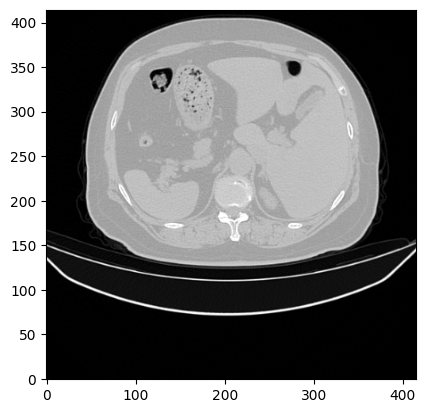

In [ ]:
plt.imshow(result[img_key][0, :, :, 34].T.cpu(), cmap="gray", origin="lower")

In [ ]:
img = nib.load(data[0][img_key])
print(nib.aff2axcodes(img.affine))

('L', 'A', 'S')


In [ ]:
result = transform(data[19])

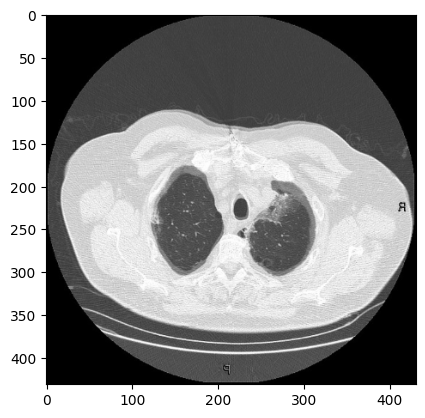

In [ ]:
plt.imshow(result[img_key][0, :, :, 34].T.cpu(), cmap="gray")

In [ ]:
img = nib.load(data[19][img_key])
print(nib.aff2axcodes(img.affine))

('L', 'A', 'S')
